In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import savgol_filter
from sklearn import metrics

# RMSE 均方根误差
def rmse(y, yhat):
    return np.sqrt(metrics.mean_squared_error(y, yhat))

def moving_average(interval, windowsize):
    window = np.ones(int(windowsize)) / float(windowsize)
    re = np.convolve(interval, window, 'same')
    return re

# SMAPE
def smape(y, yhat):
    return 2.0 * np.mean(np.abs(yhat - y) / (np.abs(yhat) + np.abs(y))) * 100

serScada=pd.read_csv('./data/serScada.csv', index_col=0)
# 字符转标准时间索引
serScada.index = pd.to_datetime(serScada.index)
serScada

,num,wind speed(m/s),wind direction,theoretical power(kW),active power(kW)
2018-01-01 00:00:00,1,5.311336,259.994904,416.328908,380.047791
2018-01-01 00:10:00,2,5.672167,268.641113,519.917511,453.769196
2018-01-01 00:20:00,3,5.216037,272.564789,390.900016,306.376587
2018-01-01 00:30:00,4,5.659674,271.258087,516.127569,419.645905
2018-01-01 00:40:00,5,5.577941,265.674286,491.702972,380.650696
...,...,...,...,...,...
2018-12-31 23:10:00,52556,11.404030,80.502724,3397.190793,2963.980957
2018-12-31 23:20:00,52557,7.332648,84.062599,1173.055771,1684.353027
2018-12-31 23:30:00,52558,8.435358,84.742500,1788.284755,2201.106934
2018-12-31 23:40:00,52559,9.421366,84.297913,2418.382503,2515.694092


In [7]:
z = np.loadtxt(open('./predict-wind-turbine/compare_filter/z_rmse.csv', "rb"), delimiter = ",", skiprows = 0)
z[2,1:]

array([118.07156178,  83.45002455,  62.15860973,  53.19657822,
        40.60653625,  37.93748506,  45.05329491,  40.11305788,
        39.05325691,  33.44828915,  36.83082646,  48.11957506,
        28.68872287,  27.23407203])

In [8]:
res_nofilter = pd.read_csv('./predict-wind-turbine/compare_filter/nofilter.csv')
res_nofilter

,actual,predicted
0,0.000000,19.868088
1,0.000000,17.065500
2,0.000000,7.360196
3,0.000000,10.716712
4,0.000000,10.973560
...,...,...
10505,3397.190793,3539.178500
10506,1173.055771,3322.271500
10507,1788.284755,1766.140100
10508,2418.382503,2657.580800


In [9]:
rmse(res_nofilter.values[:,0], res_nofilter.values[:,1])

278.76915025893885

In [10]:
rmse_sg_actual=np.zeros(15)
for i in [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]:
#     print(i)
    filter = pd.read_csv('./predict-wind-turbine/compare_filter/SG_'+str(i)+'_2.csv')
    rmse_sg_actual[(i-1)//2-1]=rmse(filter.values[:,1],res_nofilter.values[:,0])
    

rmse_sg_actual

array([281.25450675, 115.52007879, 153.49640112, 170.99075813,
       187.61057739, 202.78098613, 215.08859174, 226.97063352,
       236.79792742, 248.0361013 , 258.53869851, 266.47419708,
       273.90758508, 282.26112029, 285.24925798])

In [11]:
(rmse_sg_actual[0]-rmse_sg_actual[1])/rmse_sg_actual[0]*100

58.92685236438177

In [12]:
smape_sg_actual=np.zeros(15)
for i in [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]:
#     print(i)
    filter = pd.read_csv('./predict-wind-turbine/compare_filter/SG_'+str(i)+'_2.csv')
    smape_sg_actual[(i-1)//2-1]=smape(filter.values[:,1],res_nofilter.values[:,0])
    

smape_sg_actual

array([39.597209  , 32.26976693, 36.81387033, 34.69933943, 36.09288772,
       38.39434451, 38.23913781, 37.12539913, 38.95992012, 40.05911221,
       39.03453998, 40.73105034, 40.80421061, 40.30587234, 40.97395234])

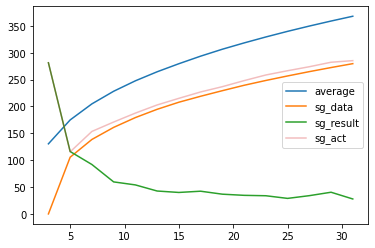

In [13]:
x = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
y1 = np.zeros(15)
y2 = np.zeros(15)
y3 = z[1,0:]
y4 = rmse_sg_actual
for i in range(len(x)):
    TP_av = moving_average(serScada['theoretical power(kW)'].values, x[i])
    RMSE_av = rmse(serScada['theoretical power(kW)'].values, TP_av)
    TP_sg = savgol_filter(serScada['theoretical power(kW)'].values, x[i], 2)
    RMSE_sg = rmse(serScada['theoretical power(kW)'].values, TP_sg)
    y1[i] = RMSE_av
    y2[i] = RMSE_sg


plt.plot(x,y1,label='average')
plt.plot(x,y2,label='sg_data')
plt.plot(x,y3,label='sg_result')
plt.plot(x,y4,label='sg_act',alpha=.3)
plt.legend()
plt.show()

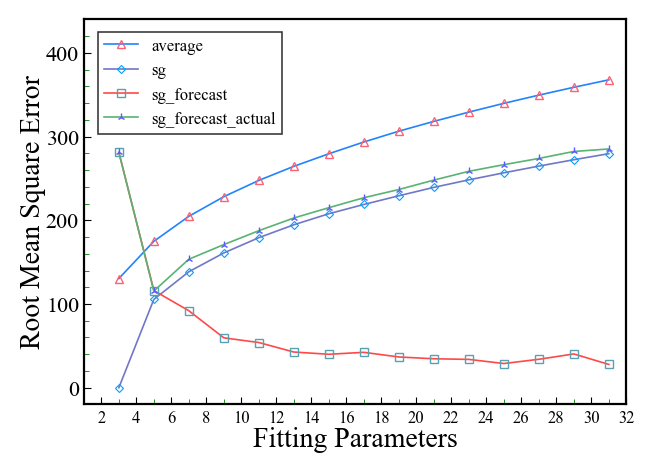

In [52]:
matplotlib.rcdefaults()  # 将配置重置为默认值
# matplotlib.use("Agg")
# matplotlib.rcParams['text.usetex'] = True  # 全局开启
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)
ax.plot(x, y1,
        label='average',
        ls='-',
        linewidth=0.6,
        color='#2184FC',
        alpha=1,
        marker='^',
        markersize=3,
        markeredgecolor='#FD6174',
        markeredgewidth=0.5,
        markerfacecolor='none')
ax.plot(x, y2,
        label='sg',
        ls='-',
        linewidth=0.6,
        color='#7177C7',
        alpha=1,
        marker='D',
        markersize=2,
        markeredgecolor='#00A2FF',
        markeredgewidth=0.4,
        markerfacecolor='none')
ax.plot(x, y3,
        label='sg_forecast',
        ls='-',
        linewidth=0.6,
        color='#ff4949',
        alpha=1,
        marker='s',
        markersize=3,
        markeredgecolor='#59A1B0',
        markeredgewidth=0.5,
        markerfacecolor='none')
ax.plot(x, y4,
        label='sg_forecast_actual',
        ls='-',
        linewidth=0.6,
        color='#5AB273',
        alpha=1,
        marker='2',
        markersize=3,
        markeredgecolor='#5858ff',
        markeredgewidth=0.5,
        markerfacecolor='none')

# 横轴设置
plt.xticks(x)
ax.set_xlabel('Fitting Parameters', fontsize=10, labelpad=0)  # 设置 x 轴标签、字体大小
ax.tick_params(axis='x', direction='in', pad=2, labelsize=6, length=2.7, width=0.4, rotation=0)  # x 轴刻度值大小
ax.tick_params(axis="x", which='minor', direction='in', length=1.7, width=0.3, color="green")
# 主刻度间隔数量
# ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(2)) # MultipleLocator()函数设置了x轴相邻显示点的间隔
# 次刻度标签的位置
ax.xaxis.set_minor_locator(plt.MultipleLocator(1)) #将此y轴次刻度标签设置为 的倍数/
plt.xlim((1, 32))

# 纵轴设置
ax.set_ylabel(r'Root Mean Square Error', fontsize=10, labelpad=0)  # 设置第 1 个 y 轴特征标签字体颜色、大小r'\textit{'+plot1.columns.values[0]+'}'
ax.tick_params(axis='y', direction='in', pad=1.7, labelsize=8, length=2.4, width=0.4)  # 第 1 个 y 轴刻度值字体颜色大小, labelcolor=color
ax.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
# 设置主刻度标签的位置
ax.yaxis.set_major_locator(plt.MultipleLocator(100)) #将y轴主刻度标签设置为 的倍数
# 设置次刻度标签的位置
ax.yaxis.set_minor_locator(plt.MultipleLocator(20)) #将此y轴次刻度标签设置为 的倍数/
plt.ylim((-20, 440))

# 设置刻度轴旋转角度：使用ax.tick_params
# ax.tick_params(axis='x', direction='in', labelsize=10, pad=5, labelrotation=0) #选择x轴
# ax.tick_params(axis='y', direction='in', labelsize=10, pad=5)

# 显示图例
plt.legend()
legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=6)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

# plt.grid(ls='--', linewidth=0.4)  # 网格

plt.savefig('temp/compare_result_filter_rmse_3.png', dpi=600)
plt.show()
plt.close(fig)

cn

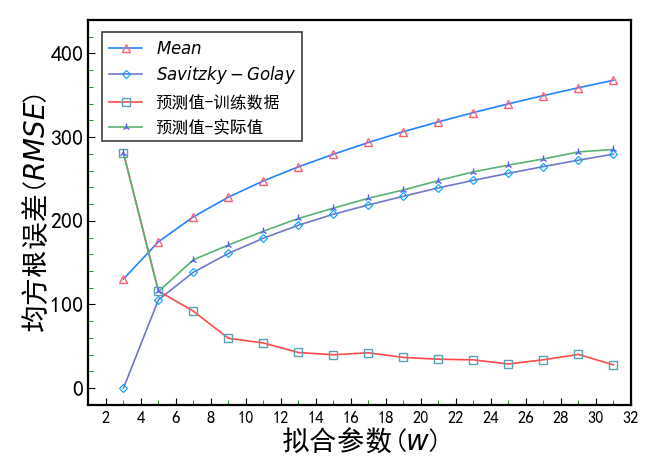

In [18]:
matplotlib.rcdefaults()  # 将配置重置为默认值
# matplotlib.use("Agg")
# matplotlib.rcParams['text.usetex'] = True  # 全局开启
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题/让负号正常显示

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)
ax.plot(x, y1,
        label='$Mean$',
        ls='-',
        linewidth=0.6,
        color='#2184FC',
        alpha=1,
        marker='^',
        markersize=3,
        markeredgecolor='#FD6174',
        markeredgewidth=0.5,
        markerfacecolor='none')
ax.plot(x, y2,
        label='$Savitzky-Golay$',
        ls='-',
        linewidth=0.6,
        color='#7177C7',
        alpha=1,
        marker='D',
        markersize=2,
        markeredgecolor='#00A2FF',
        markeredgewidth=0.4,
        markerfacecolor='none')
ax.plot(x, y3,
        label='预测值-训练数据',
        ls='-',
        linewidth=0.6,
        color='#ff4949',
        alpha=1,
        marker='s',
        markersize=3,
        markeredgecolor='#59A1B0',
        markeredgewidth=0.5,
        markerfacecolor='none')
ax.plot(x, y4,
        label='预测值-实际值',
        ls='-',
        linewidth=0.6,
        color='#5AB273',
        alpha=1,
        marker='2',
        markersize=3,
        markeredgecolor='#5858ff',
        markeredgewidth=0.5,
        markerfacecolor='none')

# 横轴设置
plt.xticks(x)
ax.set_xlabel('拟合参数($w$)', fontsize=10, labelpad=0)  # 设置 x 轴标签、字体大小
ax.tick_params(axis='x', direction='in', pad=2, labelsize=6, length=2.7, width=0.4, rotation=0)  # x 轴刻度值大小
ax.tick_params(axis="x", which='minor', direction='in', length=1.7, width=0.3, color="green")
# 主刻度间隔数量
# ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(2)) # MultipleLocator()函数设置了x轴相邻显示点的间隔
# 次刻度标签的位置
ax.xaxis.set_minor_locator(plt.MultipleLocator(1)) #将此y轴次刻度标签设置为 的倍数/
plt.xlim((1, 32))

# 纵轴设置
ax.set_ylabel(r'均方根误差($RMSE$)', fontsize=10, labelpad=0)  # 设置第 1 个 y 轴特征标签字体颜色、大小r'\textit{'+plot1.columns.values[0]+'}'
ax.tick_params(axis='y', direction='in', pad=1.7, labelsize=8, length=2.4, width=0.4)  # 第 1 个 y 轴刻度值字体颜色大小, labelcolor=color
ax.tick_params(axis="y", which='minor', direction='in', length=1.7, width=0.3, color="green")
# 设置主刻度标签的位置
ax.yaxis.set_major_locator(plt.MultipleLocator(100)) #将y轴主刻度标签设置为 的倍数
# 设置次刻度标签的位置
ax.yaxis.set_minor_locator(plt.MultipleLocator(20)) #将此y轴次刻度标签设置为 的倍数/
plt.ylim((-20, 440))

# 设置刻度轴旋转角度：使用ax.tick_params
# ax.tick_params(axis='x', direction='in', labelsize=10, pad=5, labelrotation=0) #选择x轴
# ax.tick_params(axis='y', direction='in', labelsize=10, pad=5)

# 显示图例
plt.legend()
legend = plt.legend(loc='upper left', frameon=True, bbox_to_anchor=(0.01, 0.99), ncol=1,fancybox=False,
                    facecolor='white',edgecolor='black', fontsize=6)
frame = legend.get_frame()
frame.set_linewidth(0.57) # 设置图例边框线宽

# plt.grid(ls='--', linewidth=0.4)  # 网格

plt.savefig('temp/compare_result_filter_rmse_4.png', dpi=600)
plt.show()
plt.close(fig)